#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [1]:
!pip install -q pymap3d


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin

# Example usage
# points_3d = np.random.rand(100, 3)
# opt_points_3d = np.random.rand(100, 3)

import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])# Example usage
# points_3d = np.random.rand(100, 3)
# opt_points_3d = np.random.rand(100, 3)


In [ ]:
# !unzip -q /content/optical-edge-dev.zip
!unzip -q /content/optical-edge-dev_v2.zip

------

In [ ]:
# !unzip -q sample-dataset-xs.zip
!unzip -q data.zip

replace data/berlin/config.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/berlin/ground_control_points.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/images/01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/images/02.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/images/03.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/masks/01.jpg.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/masks/02.jpg.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/masks/03.jpg.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/reconstruction_example.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/rig_assignments_example.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/rig_cameras_example.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/berlin/sequence_database.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
re

In [3]:
sys.path.append('/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
# sys.path.append('/content/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [4]:
sys.path.append('/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
import Utils
from Utils import *

In [19]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files/Utils.py'>

### Google Colab (implementation)

In [5]:
# sample_dataset_path = r"/content/sample-dataset-xs"
name = 'lund'
sample_dataset_path = f"/home/datademon/Desktop/Alik/OpenSfM/data/{name}/images"

----

### WorkStation (Implementation)

In [5]:
flight_num = 'E240'
sample_dataset_dir = f"/home/datademon/Desktop/Alik/Data/{flight_num}/cam"
print(os.listdir(sample_dataset_dir))
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

['strip_E240_1679940139', 'strip_E240_1679940278', 'strip_E240_1679940007', 'strip_E240_1679940412']
['strip_E240_1679940139', 'strip_E240_1679940278', 'strip_E240_1679940007', 'strip_E240_1679940412']


In [6]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/Alik/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

Strip-Selected:  strip_E240_1679940139
Save-Path:  /home/datademon/Desktop/Alik/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E240/flight_parameters_estimation_strip_E240_1679940139.csv
No. of Samples:  354
['img_E240_491926700394_1679940139_415820771.tiff', 'img_E240_492259980942_1679940139_748596603.tiff']
['strip_E240_1679940139', 'strip_E240_1679940278', 'strip_E240_1679940007', 'strip_E240_1679940412']


-----------

##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

No. of Samples:  5
['img_E240_491926700394_1679940139_415820771.tiff', 'img_E240_492259980942_1679940139_748596603.tiff', 'img_E240_492593270400_1679940140_82380554.tiff', 'img_E240_492926563935_1679940140_415662733.tiff', 'img_E240_493593145794_1679940141_82383446.tiff']
(1200, 1920, 3)


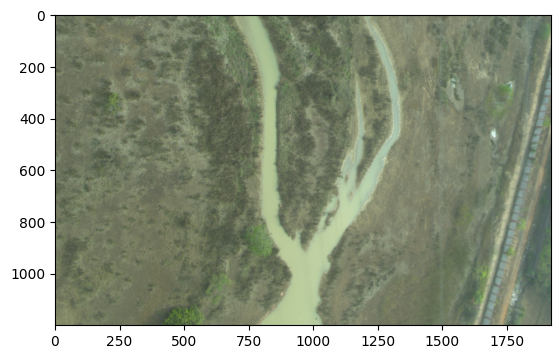

In [7]:
sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if (path.endswith('.tiff') or path.endswith('.jpg'))]

def key_fn_tiff(item):
  return item.split('_')[2]

# sample_dir = sorted(sample_dir, key=key_fn_tiff, reverse=False)
sample_dir = sorted(sample_dir, reverse=False)

''' Taking only n=100 samples for stitching '''
num_take = 5
sample_dir = sample_dir[:num_take]

print('No. of Samples: ', len(sample_dir))
print(sample_dir)

test_img = cv2.imread(os.path.join(sample_dataset_path, sample_dir[0]))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_shape = test_img.shape

print(test_img_shape)
plt.imshow(test_img)
plt.show()

In [8]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940139_415820771', '1679940139_748596603', '1679940140_82380554', '1679940140_415662733', '1679940141_82383446']
['2023-03-27 23:32:19.415821', '2023-03-27 23:32:19.748597', '2023-03-27 23:32:20.082381', '2023-03-27 23:32:20.415663', '2023-03-27 23:32:21.082383']

Time-Wise Path Storages -



Random-ENT:  0
t = 2023-03-27 23:32:19.415821 --> img_E240_491926700394_1679940139_415820771.tiff UTC , t = 2023-03-27 23:32:19.748597 --> img_E240_492259980942_1679940139_748596603.tiff UTC
(1200, 1920, 3) (1200, 1920, 3)


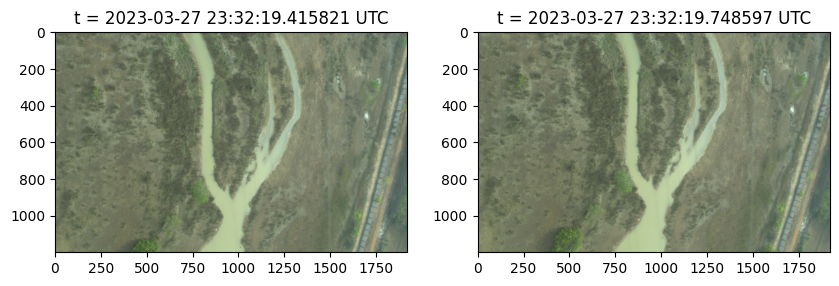

In [9]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

### Optical-Stitching

(5, 1200, 1920, 3)


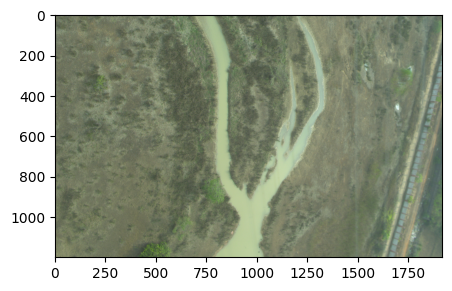

In [10]:
# image_size = (720, 720)
image_size = test_img_shape[:-1][::-1]

resized_frames = np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(sample_dataset_path, nm)), cv2.COLOR_BGR2RGB), image_size) for nm in sample_dir])
print(resized_frames.shape)
# resized_frames = np.array([resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0]])
# print(resized_frames.shape)

fig = plt.figure(figsize = (5, 5))

plt.imshow(resized_frames[0])
plt.show()

### Translation-Vector-Error

In [11]:
num_frames = len(resized_frames)

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75

Num-Frames:  5


In [12]:
import time

t_err = []
euler_angle_list = []
translation_list = []
ft = time.time()

for i in tqdm((range(num_frames)), desc="Extracting t-Error Values", unit="frame"):

  temp_resized_frames = np.array([resized_frames[i], resized_frames[i]])
  # print(temp_resized_frames.shape)

  for j in range(len(temp_resized_frames)):

    if j == 0:
        result_img = temp_resized_frames[j]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = temp_resized_frames[j]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        # result_img = manual_stitch_frames(Image2, Image1)

        t_err.append(t)
        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if j == 1:

          prev_R = curr_R
          prev_t = curr_t

          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)


        result_img = manual_stitch_frames(Image2, Image1, prev_R, np.squeeze(prev_t), curr_R, np.squeeze(curr_t))

        prev_R = curr_R
        prev_t = abs(curr_t)
  pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

t_err = np.array(t_err)
print(t_err.shape)

Extracting t-Error Values:   0%|          | 0/5 [00:00<?, ?frame/s]

Extracting t-Error Values:  20%|██        | 1/5 [00:00<00:03,  1.05frame/s]

Extracting t-Error Values:  40%|████      | 2/5 [00:01<00:02,  1.07frame/s]

Extracting t-Error Values:  60%|██████    | 3/5 [00:02<00:01,  1.09frame/s]

Extracting t-Error Values:  80%|████████  | 4/5 [00:03<00:00,  1.10frame/s]

Extracting t-Error Values: 100%|██████████| 5/5 [00:04<00:00,  1.10frame/s]

Execution-time (UNIX):  4.566227197647095
(5, 3, 1)


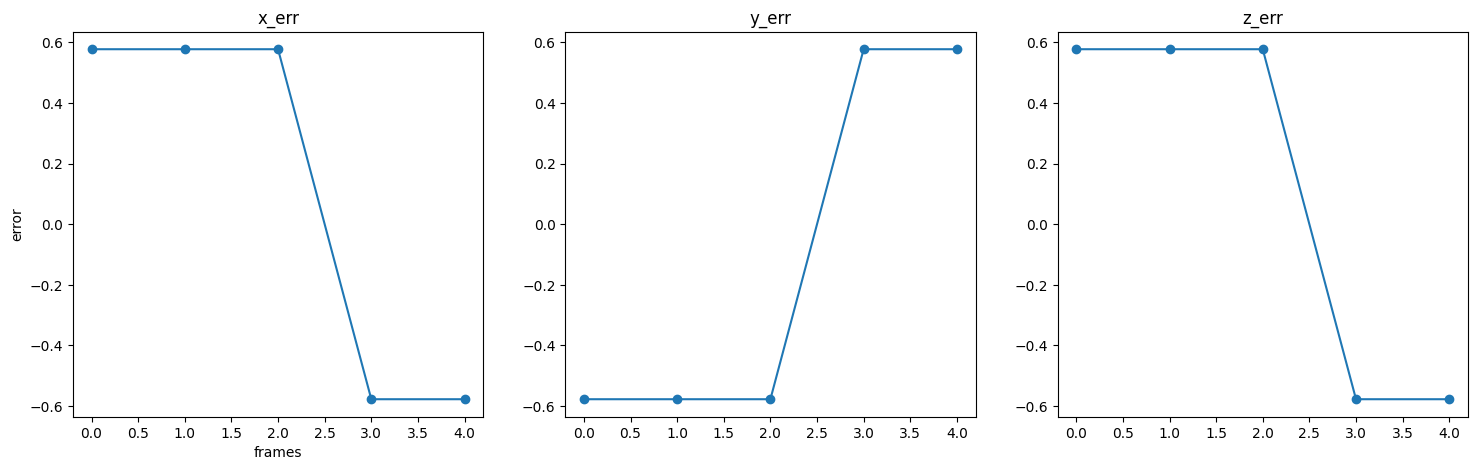

In [14]:
''' SANITY-CHECK '''

# t_err = 10 * np.ones(t_err.shape)
# print(t_err.shape)

t_err = np.squeeze(t_err)
x_err, y_err, z_err = t_err[:, 0], t_err[:, 1], t_err[:, -1]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

axs[0].plot(x_err, marker = 'o')
axs[0].set_title('x_err')
axs[0].set_xlabel('frames')
axs[0].set_ylabel('error')


axs[1].plot(y_err, marker = 'o')
axs[1].set_title('y_err')

axs[2].plot(z_err, marker = 'o')
axs[2].set_title('z_err')

plt.show()

In [ ]:
# resized_frames = np.array([resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0], resized_frames[0]])
# print(resized_frames.shape)

Num-Frames:  5


Stitching frames:   0%|          | 0/5 [00:00<?, ?frame/s]

Stitching frames:  40%|████      | 2/5 [00:00<00:01,  2.07frame/s]

Stitching frames:  60%|██████    | 3/5 [00:01<00:01,  1.48frame/s]

Stitching frames:  80%|████████  | 4/5 [00:02<00:00,  1.24frame/s]

Stitching frames: 100%|██████████| 5/5 [00:03<00:00,  1.25frame/s]


Execution-time (UNIX):  3.9938552379608154


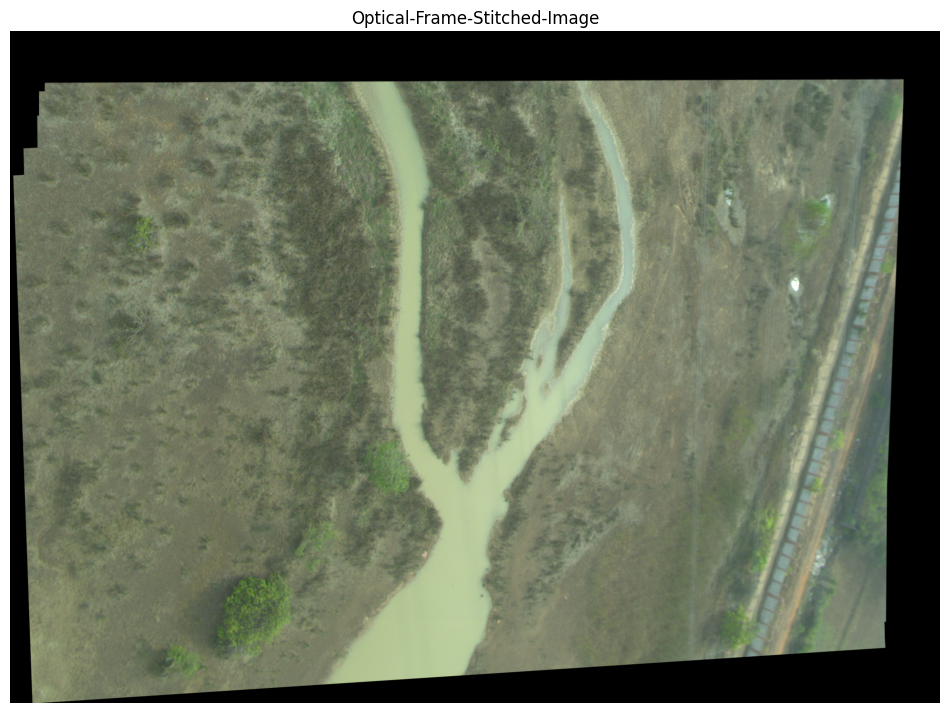

In [15]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)

euler_angle_list = []
translation_list = []

t_corr = [False, t_err]

ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # t_corr[0] = False

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(t_corr = t_corr, is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        euler_angle_list.append(euler_angle)

        # Calling function for stitching images.prev_t
        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        if i == 1:
          prev_R = curr_R
          prev_t = curr_t

          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        result_img = manual_stitch_frames(Image2, Image1, prev_R, np.squeeze(prev_t), curr_R, np.squeeze(curr_t))

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

# result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

In [40]:
import tifffile

nm = 'abc' + '3' #+ '_corr'
tifffile.imwrite(f'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/{nm}.tiff', result_img)

['/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc2.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc0.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc1_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc3.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc0_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc2_corr.tiff',
 '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/abc1.tiff']
['/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-fligh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


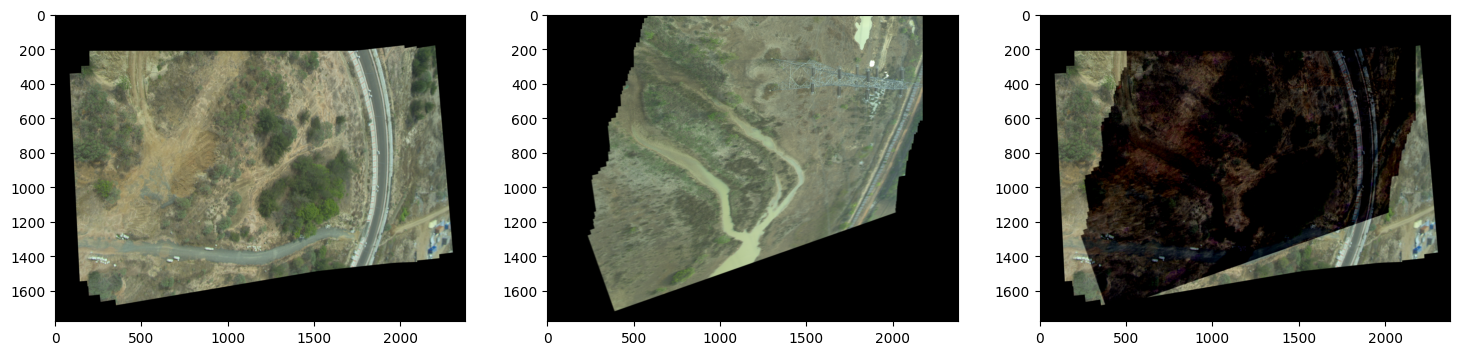

In [94]:
from PIL import Image
from pprint import pprint

parent_dir = r'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES'

req_path = [os.path.join(parent_dir, path) for path in os.listdir(parent_dir) if path[:3] == 'abc']
pprint(req_path)

print(req_path)

img, img_corr = np.asarray(Image.open(req_path[0])), np.asarray(Image.open(req_path[4]))
img, img_corr = (img / 255).astype('float64'), (img_corr / 255).astype('float64')

print(img.shape, img_corr.shape)

img_corr = cv2.resize(img_corr, (img.shape[1], img.shape[0]))

fig, axs = plt.subplots(1, 3, figsize = (18, 7))

axs[0].imshow(img)
axs[1].imshow(img_corr)
axs[2].imshow(img - img_corr)

plt.show()

# print(img[:10])
# print()
# print(img_corr[:10])

### PLOT

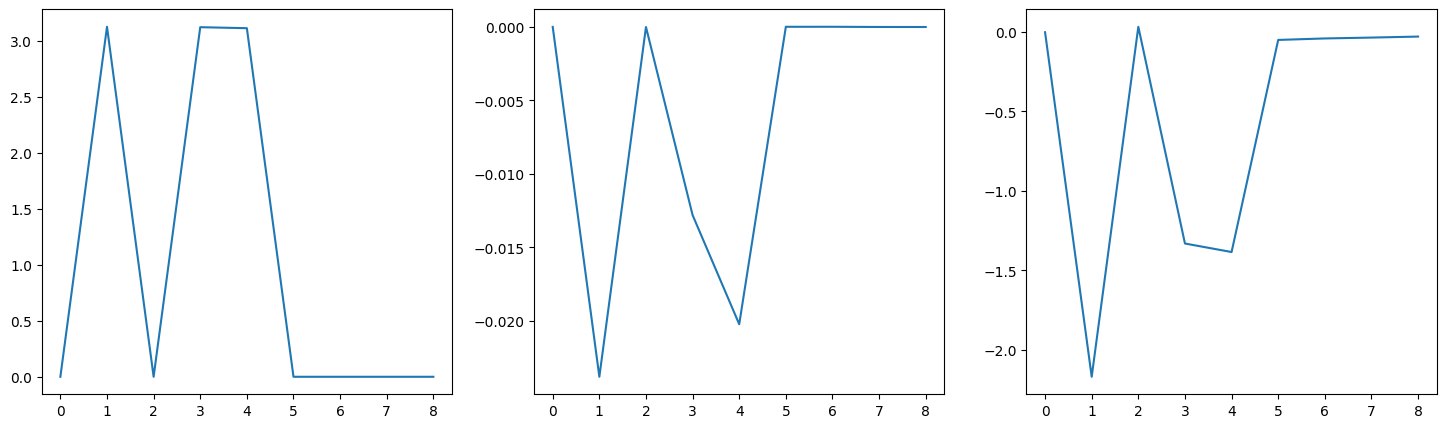

In [ ]:
# print(euler_angle_list)
euler_angle_list = np.array(euler_angle_list)
# print(euler_angle_list.shape)
roll, pitch, yaw = euler_angle_list[:, 0], euler_angle_list[:, 1], euler_angle_list[:, 2]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))

axs[0].plot(roll)
axs[1].plot(pitch)
axs[2].plot(yaw)

plt.show()

# translation_list = np.squeeze(np.array(translation_list))
# # print(translation_list.shape)
# x, y, z = translation_list[:, 0], translation_list[:, 1], translation_list[:, -1]
# # print(x, y, z)
# fig, axs = plt.subplots(1, 3, figsize = (18, 5))

# axs[0].plot(x)
# axs[1].plot(y)
# axs[2].plot(z)

# plt.show()


In [ ]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

#### Bundle Adjustment (Global Optimization)
2-view stereo view [CASE]

In [16]:
def plot_key_points(image, kp):

  output_image = image.copy()

  for _kp in kp:
    x, y = _kp.pt
    size = _kp.size
    color = (0, 255, 0)
    thickness = 2

    cv2.circle(output_image, (int(x), int(y)), int(max(1, size)), color, thickness)

  return output_image

In [17]:
def plot_feature_matches(image1, image2, keypoints1, keypoints2, good_matches):

  height1, width1 = image1.shape[:2]
  height2, width2 = image2.shape[:2]

  combined_img = cv2.hconcat([image1, image2])

  for match in good_matches:
    m_idx = match[0].queryIdx
    n_idx = match[0].trainIdx

    (x1, y1) = keypoints1[m_idx].pt
    (x2, y2) = keypoints2[n_idx].pt

    start_point = (int(x1), int(y1))
    end_point = (int(width1 + x2), int(y2))

    cv2.line(combined_img, start_point, end_point, (255, 0, 0), 5)

  return combined_img


(1200, 1920, 3) (1200, 1920, 3)


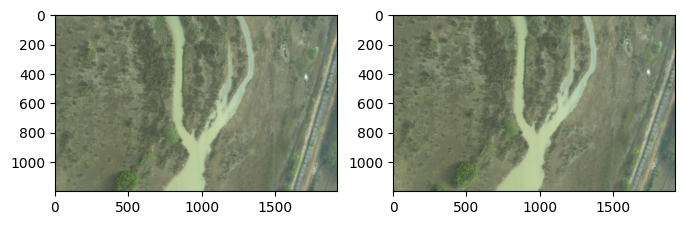

In [18]:
seed_num = 1
first_frame, second_frame = resized_frames[seed_num], resized_frames[seed_num + 1]
# first_frame, second_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
print(first_frame.shape, second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (8, 8))
axs[0].imshow(first_frame)
axs[1].imshow(second_frame)

plt.show()

In [19]:
sift = cv2.SIFT_create()
baseImage_kp, baseImage_des = sift.detectAndCompute(cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY), None)
secImage_kp, secImage_des = sift.detectAndCompute(cv2.cvtColor(second_frame, cv2.COLOR_RGB2GRAY), None)

print("(x, y): ", baseImage_kp[0].pt, ', radius: ', baseImage_kp[0].size)

(x, y):  (38.001922607421875, 683.4639282226562) , radius:  4.037287712097168


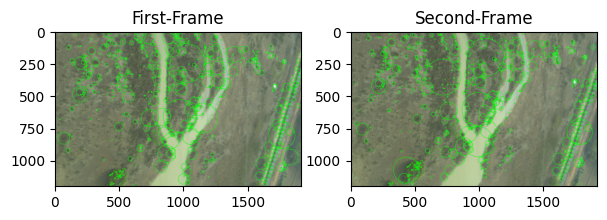

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(plot_key_points(first_frame, baseImage_kp))
axs[0].set_title('First-Frame')
axs[1].imshow(plot_key_points(second_frame, secImage_kp))
axs[1].set_title('Second-Frame')

plt.show()

In [21]:
BF_Matcher = cv2.BFMatcher()
InitialMatches = BF_Matcher.knnMatch(baseImage_des, secImage_des, k=2)

# Applying ratio test and filtering out the good matches.
GoodMatches = []
threshold = 0.75
for m, n in InitialMatches:
    if m.distance < threshold * n.distance: ## Within 75% CI
        GoodMatches.append([m])

print('No. of Good Matches: ', len(GoodMatches))

No. of Good Matches:  725


In [22]:
rand_idx = np.random.permutation(len(GoodMatches))[:20]
some_GoodMatches = [GoodMatches[i] for i in rand_idx]

(1200, 3840, 3)


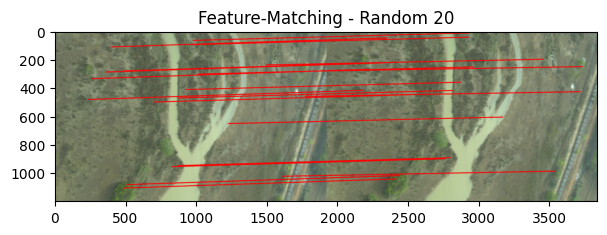

In [23]:
output_image = plot_feature_matches(first_frame, second_frame, baseImage_kp, secImage_kp, some_GoodMatches)
print(output_image.shape)

fig = plt.figure(figsize = (7, 7))

plt.imshow(output_image)
plt.title('Feature-Matching - Random 20')

plt.show()

Recover Camera Pose (R, T) + K (camera-matrix) to find camera projection matric (P) --> Find 3D-coordinates (using traingulation) --> Perform non-linear optimization (least-squares) (Ceres Solver) to optimize (3D coordinates and extrinsic parameters)   

In [24]:
def calculate_projection_matrix(K, R, t):
    P = np.zeros((3, 4))
    P[:3, :3] = R @ K
    P[:3, 3] = t.flatten()

    return P

def traingulate(x1, x2, P1, P2):

  A = np.zeros((4, 4))
  A[0] = x1[0] * P1[2] - P1[0]
  A[1] = x1[1] * P1[2] - P1[1]
  A[2] = x2[0] * P2[2] - P2[0]
  A[3] = x2[1] * P2[2] - P2[1]

  U, S, Vt = np.linalg.svd(A)
  V = Vt.T
  X = V[:, -1]  # Last column of V is the 3D point

  return X / X[3]  # Normalize to homogeneous coordinates

In [25]:
baseImage_pts, secImage_pts = [], []
print('Camera-Matrix: ', camera_matrix)

for match in GoodMatches:
    baseImage_pts.append(baseImage_kp[match[0].queryIdx].pt)
    secImage_pts.append(secImage_kp[match[0].trainIdx].pt)

first_pose = [np.eye(3), np.zeros((3, 1))]
E, mask = cv2.findEssentialMat(np.array(baseImage_pts), np.array(secImage_pts), camera_matrix, method = cv2.RANSAC)
_, R, t, mask = cv2.recoverPose(E, np.array(baseImage_pts), np.array(secImage_pts), camera_matrix)
second_pose = [R @ first_pose[0], R @ first_pose[-1] + t]

print(first_pose)
print()
print(second_pose)

P1, P2 = calculate_projection_matrix(camera_matrix, R, t), calculate_projection_matrix(camera_matrix, R, t)
print()
print('Camera-Projection-Matrix: ')
print(P1, P2)
print(P1.shape, P2.shape)

select_point_2d = 2
x1, x2 = baseImage_kp[select_point_2d].pt, secImage_kp[select_point_2d].pt
print('(x1, x2) : ', x1, x2)


Camera-Matrix:  [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]])]

[array([[ 0.99980016, -0.01979846,  0.00276892],
       [ 0.01982097,  0.99976865, -0.00835366],
       [-0.00260289,  0.00840687,  0.99996127]]), array([[ 0.46436276],
       [-0.88415619],
       [-0.05133284]])]

Camera-Projection-Matrix: 
[[ 7.18712342e+02 -1.42322433e+01  6.03407240e+02  4.64362756e-01]
 [ 1.42484256e+01  7.18689690e+02  1.97199648e+02 -8.84156191e-01]
 [-1.87110453e+00  6.04333067e+00  9.76588752e-01 -5.13328384e-02]] [[ 7.18712342e+02 -1.42322433e+01  6.03407240e+02  4.64362756e-01]
 [ 1.42484256e+01  7.18689690e+02  1.97199648e+02 -8.84156191e-01]
 [-1.87110453e+00  6.04333067e+00  9.76588752e-01 -5.13328384e-02]]
(3, 4) (3, 4)
(x1, x2) :  (68.75395202636719, 830.30078125) (43.13286590576172, 715.2434692382812)


In [26]:
print(traingulate(x1, x2, P1, P2).shape)
point_3d = traingulate(x1, x2, P1, P2)[:-1]

two_cam_centers = [-np.matmul(first_pose[0].T, first_pose[-1]), -np.matmul(second_pose[0].T, second_pose[-1])]
cam1_center, cam2_center = two_cam_centers

print(two_cam_centers)

(4,)
[array([[-0.],
       [-0.],
       [-0.]]), array([[-0.44687873],
       [ 0.89357686],
       [ 0.04265913]])]


### Plot 3-D Dynamics | from Triangulation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BA-2-View


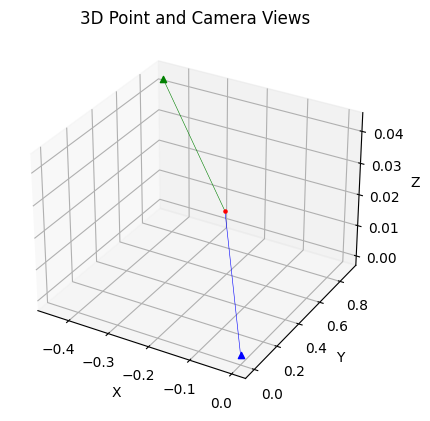

In [28]:
def two_single_3d_plot(two_cam_centers, point_3d): ## During BA, how a 3D points in WCS changes + how camera pose for consecutive frames changes

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cam1_center, cam2_center = two_cam_centers
    ax.scatter(point_3d[0], point_3d[1], point_3d[2], c='r', marker='.')
    ax.scatter(cam1_center[0], cam1_center[1], cam1_center[2], c='b', marker='^')
    ax.scatter(cam2_center[0], cam2_center[1], cam2_center[2], c='g', marker='^')

    x1, y1, z1 = ([cam1_center[0][0], point_3d[0]]), [cam1_center[1][0], point_3d[1]], [cam1_center[-1][0], point_3d[-1]]
    x2, y2, z2 = ([cam2_center[0][0], point_3d[0]]), [cam2_center[1][0], point_3d[1]], [cam2_center[-1][0], point_3d[-1]]

    ax.plot(x1, y1, z1, c='b', linewidth = 0.4)
    ax.plot(x2, y2, z2, c='g', linewidth = 0.4)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point and Camera Views')

two_single_3d_plot(two_cam_centers, point_3d)

print('BA-2-View')

plt.show()

#### Optimization

In [29]:
import time
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares
import urllib
import bz2

Sample-Run

last 2 dim for a focal distance and two distortion parameters


    1. camera_params (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector, next 3 components form a translation vector, then a focal distance and two distortion parameters. <br>
    2. points_3d (n_points, 3) contains initial estimates of point coordinates in the world frame. <br>
    3. camera_ind (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation. <br>
    4. point_ind (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation. <br>
    5. points_2d (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.


In [30]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

temp_camera_params, temp_points_3d, temp_camera_indices, temp_point_indices, temp_points_2d = read_bal_data(FILE_NAME)
camera_feature = 6
temp_camera_params = temp_camera_params[:, :camera_feature]
print(temp_camera_params.shape, temp_points_3d.shape, temp_points_2d.shape)
print()
print(temp_camera_indices.shape, temp_point_indices.shape)
print(temp_camera_indices[:10], temp_point_indices[:10])
print(len(set(temp_camera_indices)), len(set(temp_point_indices)))
print(temp_points_2d[:10])

(49, 6) (7776, 3) (31843, 2)

(31843,) (31843,)
[ 0  1  3 26 29 36  0  1  4  8] [0 0 0 0 0 0 1 1 1 1]
49 7776
[[-332.65     262.09   ]
 [-199.76     166.7    ]
 [-253.06     202.27   ]
 [  58.13     271.89   ]
 [ 238.22     237.37   ]
 [ 317.55     221.15   ]
 [ 122.41      65.54999]
 [ 123.39      60.03003]
 [ 122.68      70.53998]
 [ 126.96      77.32001]]


In [31]:
print(temp_points_3d.shape, temp_points_3d.shape[0] * temp_points_3d.shape[1], temp_point_indices.shape)
print(temp_points_3d.shape)
print(temp_points_3d[temp_point_indices].shape)

print(temp_points_3d[temp_point_indices][:], temp_points_3d[0])

(7776, 3) 23328 (31843,)
(7776, 3)
(31843, 3)
[[-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 [-0.61200016  0.57175905 -1.84708128]
 ...
 [-0.81934825  0.07654737 -4.51433696]
 [-0.74800017  0.03709491 -4.8131693 ]
 [-0.74800017  0.03709491 -4.8131693 ]] [-0.61200016  0.57175905 -1.84708128]


### Feedback-Cyclic Execution
<br>
for the scipy dataset, match all 2D feature point to every other 2D feature point and triangulate 3D points and match them with the existing 3D corpus - Now in BA execution bypass the feature detection and matching method and check if - 
- 
<br>
<li> Correct 3D Triangulation </li>
<li> Expected Point & Camera Indexing </li>
    

In [ ]:
def build_visibility_matrix(inlier_X_all_indices, inlier_ids, curr_cam_id):
    '''
    Visibility matrix: relationship between a camera and point, construct a I×J
    binary matrix, V where V_ij is one if the j_th point is visible from the i_th
    camera and zero otherwise.
    '''
    temp = np.zeros((inlier_ids.shape[0]), dtype=int)
    # print(temp[:5], temp.shape)
    ## For image columns upto current image i.e. if curr_cam_id =2 -> upto 3rd image
    ## Binary matrix for points that are in any views upto curr_cam_id
    for i in range(curr_cam_id + 1):
        temp = temp | inlier_ids[:,i]
    
    three_d_inliers = inlier_X_all_indices.reshape(-1)
    # Indices of the 3D inliers present in views upto curr_cam_id
    X_ids = np.where(three_d_inliers & temp)
    # Indices of those inlier pts
    vis_matrix = inlier_X_all_indices[X_ids].reshape(-1,1)

    for i in range(curr_cam_id + 1):
        vis_matrix = np.concatenate((vis_matrix, inlier_ids[X_ids, i].reshape(-1,1)), axis=1)
    
    _, w = vis_matrix.shape
    vis_matrix = vis_matrix[:, 1:w]

    return X_ids, vis_matrix

def get_2d_points_camera_indices(X_ids, features_x, features_y, v_mat):
    '''
    2D point correspondences of their 3D counterparts from visibility matrix 
    (present in all views upto current cam_id)
    '''
    pts_2d = []
    point_ids, camera_ids = [], []
    vis_x_feats = features_x[X_ids]
    vis_y_feats = features_y[X_ids]
    for i in range(v_mat.shape[0]): # rows on visibility matrix
        for j in range(v_mat.shape[1]): # columns on visibility matrix
            if v_mat[i,j] == 1:
                pts_2d.append(np.hstack((vis_x_feats[i,j], vis_y_feats[i,j])))
                point_ids.append(i) # rows==matches
                camera_ids.append(j) # columns==images
    #
    points_2d = np.array(pts_2d).reshape(-1, 2)
    # Indices of visible points
    point_ids = np.array(point_ids).reshape(-1)
    # Indices of visible cameras
    camera_ids = np.array(camera_ids).reshape(-1)

    return points_2d, point_ids, camera_ids


In [32]:
def rotate(points, rot_vecs):

    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def project_2d_upd(points, camera_params):

    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]

    return points_proj

def project_2d(points, camera_params):

    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:camera_feature]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]

    # fx, fy = camera_params[:, camera_feature], camera_params[:, camera_feature]
    # f = (fx + fy) / 2
    # points_proj *= f[:, np.newaxis]

    return points_proj

def func(params, n_cameras, n_points, camera_indices, point_indices, points_2d):

    camera_params = params[:n_cameras * camera_feature].reshape((n_cameras, camera_feature))
    points_3d = params[n_cameras * camera_feature:].reshape((n_points, 3))

    # points_proj = project_2d_upd(points_3d[point_indices], camera_params[camera_indices])
    points_proj = project_2d(points_3d[point_indices], camera_params[camera_indices])
    cost = (points_proj - points_2d).ravel()
    return cost

In [33]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * camera_feature + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(camera_feature):
        A[2 * i, camera_indices * camera_feature + s] = 1
        A[2 * i + 1, camera_indices * camera_feature + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * camera_feature + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * camera_feature + point_indices * 3 + s] = 1

    return A

In [34]:
args = (temp_camera_params, temp_points_3d, temp_camera_indices, temp_point_indices, temp_points_2d)

In [ ]:
temp_n_cameras = temp_camera_params.shape[0]
temp_n_points = temp_points_3d.shape[0]
print(temp_point_indices.shape, temp_camera_indices.shape)

print('Number-Of-Cameras: ', temp_n_cameras)
print('Number-Of-Points: ', temp_n_points)

temp_x0 = np.hstack((temp_camera_params.ravel(), temp_points_3d.ravel()))
print('X0-Shape: ', temp_x0.shape)

f0 = func(temp_x0, temp_n_cameras, temp_n_points, temp_camera_indices,temp_point_indices, temp_points_2d)

A = bundle_adjustment_sparsity(temp_n_cameras, temp_n_points, temp_camera_indices, temp_point_indices)

t0 = time.time()

args = (temp_n_cameras, temp_n_points, temp_camera_indices, temp_point_indices, temp_points_2d)
res = least_squares(func, temp_x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-6, method='trf', max_nfev=250,
                    args=args)
t1 = time.time()

-----

In [35]:
import cv2
import numpy as np
import math
from scipy.optimize import least_squares
import bisect

In [46]:
# num_frames = len(camera_params)
# print('Number of Frames: ', num_frames)

def finding_index(target_3d_point, point_3d_corpus, inc_camera_idx_list):

    target_3d_point, point_3d_corpus = target_3d_point.T[:, :3], np.squeeze(point_3d_corpus)[:, :3]
    print(target_3d_point.shape, point_3d_corpus.shape)
    distances = np.linalg.norm(point_3d_corpus - target_3d_point, axis=1)
    closest_point_idx = np.argmin(distances)
    closest_camera_idx = bisect.bisect_right(inc_camera_idx_list, closest_point_idx) - 1

    return closest_camera_idx, closest_point_idx


def finding_index_v2(target_3d_point, point_3d_corpus, inc_camera_idx_list, error_percent = 0.0000005):
    
  closest_point_idx = []
  closest_camera_idx = []
  avg_distance = 0

  for i, p in enumerate(point_3d_corpus):
    distance = math.sqrt((p[0] - target_3d_point[0]) ** 2 + (p[1] - target_3d_point[1]) ** 2 + (p[2] - target_3d_point[2]) ** 2)
    avg_distance += distance      
    
  avg_distance = avg_distance / len(point_3d_corpus) 
  # print(avg_distance)
  _threshold = error_percent * avg_distance

  # exit()
  
  for i, p in enumerate(point_3d_corpus):
    distance = math.sqrt((p[0] - target_3d_point[0]) ** 2 + (p[1] - target_3d_point[1]) ** 2 + (p[2] - target_3d_point[2]) ** 2)
    if distance <= _threshold:
        closest_point_idx.append(i)

  for p in closest_point_idx:
    c_camera_idx = bisect.bisect_right(inc_camera_idx_list, p) - 1 
    closest_camera_idx.append(c_camera_idx)  

  return closest_camera_idx, closest_point_idx

''' Sample-Run '''
temp_3d_point = np.array([[-0.03287113],
  [-0.00326499],
  [ 0.04161941],
  [ 0.99858733]])

sample_3d_corpus = np.array([[[-0.03746069],
  [-0.00291197],
  [ 0.04606442],
  [ 0.99823158]],

 [[-0.02200075],
  [-0.00286068],
  [ 0.02786419],
  [ 0.99936548]],

 [[-0.03287113],
  [-0.00326499],
  [ 0.04161941],
  [ 0.99858733]]])

inc_camera_idx_list = [0, 2, 3]
print(temp_3d_point.shape, sample_3d_corpus.shape)
closest_camera_idx, closest_point_idx = finding_index(temp_3d_point, sample_3d_corpus, inc_camera_idx_list)
print(closest_camera_idx, closest_point_idx)

closest_camera_idx, closest_point_idx = finding_index_v2(temp_3d_point, sample_3d_corpus, inc_camera_idx_list)
print(closest_camera_idx, closest_point_idx)

(4, 1) (3, 4, 1)
(1, 3) (3, 3)
1 2
[1] [2]


#### Incremental SFM

In [47]:
def incremental_sfm(images, intrinsic_matrix, want_data = False):
    """
    Performs incremental structure-from-motion and bundle adjustment for optical stitching.
    """

    print('Runnimg Bundle Adjustment ... ')

    # Initialize variables
    points_3d = []
    camera_poses = []
    points_2d = []
    matched_points_2d = []
    descriptors = []
    camera_idx_list = []
    point_idx_list = []
    inc_camera_idx_list = []

    # Detect and compute features for all images
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = cv2.SIFT_create().detectAndCompute(gray, None)
        points_2d.append(np.array([kp[i].pt for i in range(len(kp))]))
        descriptors.append(desc)

    ### Need to match features here.
    init_matches = match_features(descriptors[0], descriptors[1])

    # print(init_matches, type(init_matches))

    m1_idx, m2_idx = init_matches[:, 0], init_matches[:, 1]
    kp1, kp2 = np.array(points_2d[0][m1_idx]), np.array(points_2d[1][m2_idx])

    E, mask = cv2.findEssentialMat(kp1, kp2, intrinsic_matrix, cv2.RANSAC)
    _, R, t, mask_triangulated = cv2.recoverPose(E, kp1, kp2, intrinsic_matrix, mask)

    camera_poses.append((np.zeros(3), np.zeros(3)))
    camera_poses.append((cv2.Rodrigues(R)[0].ravel(), t.ravel()))

    # print('AVC')

    # print('Camera-Poses: ', camera_poses, len(camera_poses))

    ## constructed 4x1 Matrix (in Homogeneous Coordinate System) | 3x4 matrix (1-dim for scale) --> camera projection matrix
    p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[0][0])[0], camera_poses[0][1])
    p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[1][0])[0], camera_poses[1][1])

    # print(p1_cam.shape, p2_cam.shape, kp1.shape, kp2.shape)

    points_3d_cur = np.array([cv2.triangulatePoints(p1_cam, p2_cam, key_0, key_1) for key_0, key_1 in zip(kp1, kp2)])
    m_points_2d = [(key_0, key_1) for key_0, key_1 in zip(kp1, kp2)]
    print()

    # print('Point_3D_shape: ', points_3d_cur.shape)

    points_3d.append(points_3d_cur)
    matched_points_2d.append(m_points_2d)

    # Incrementally add new images and points
    for i in range(2, len(images)):

        matches = match_features(descriptors[i - 1], descriptors[i])
        m1_idx, m2_idx = matches[:, 0], matches[:, 1]
        kp1, kp2 = np.array(points_2d[i - 1][m1_idx]), np.array(points_2d[i][m2_idx])

        E, mask = cv2.findEssentialMat(kp1, kp2, intrinsic_matrix, cv2.RANSAC)
        _, R, t, mask_triangulated = cv2.recoverPose(E, kp1, kp2, intrinsic_matrix, mask)

        camera_poses.append((cv2.Rodrigues(R)[0].ravel(), t.ravel()))

        ## Indexing is incorrect | Ordering is wrong
        p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[i - 1][0])[0], camera_poses[i - 1][1])
        p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[i][0])[0], camera_poses[i][1])

        if i == 2:

          # print('Projection-Camera-Matrix - ')

          print(p1_cam.shape, p2_cam.shape)

        points_3d_new = np.array([cv2.triangulatePoints(p1_cam, p2_cam, key_0, key_1) for key_0, key_1 in zip(kp1, kp2)])
        m_points_2d = [(key_0, key_1) for key_0, key_1 in zip(kp1, kp2)]

        matched_points_2d.append(m_points_2d)
        points_3d.append(points_3d_new)


    # Perform bundle adjustment
    points_3d_flat = np.array([p_ele for p in points_3d for p_ele in p]) ## Flatten all 3-D points in World-Coordinat-System, extracted from 2 view-stereo
    
    print('Points-3D: ', len(points_3d), points_3d[0].shape)

    print('Flat-3D: ', points_3d_flat.shape)

    # print('(x, y, z): ', points_3d_flat[0])
    points_2d_flat = np.array([p_ele for p in points_2d for p_ele in p])
    # print('Points-2D: ', len(points_2d))

    print('Flat-2D: ', points_2d_flat.shape)

    descriptor_flat = np.array([d_ele for d in descriptors for d_ele in d])
    # print('Descriptors: ', descriptor_flat.shape)

    print('Matched-Points-2d: ', len(matched_points_2d), np.array(matched_points_2d[0]).shape)

    matched_points_2d_flat = np.array([m_ele for m in matched_points_2d for m_ele in m])

    print('Matched_points_2d_flat: ', matched_points_2d_flat.shape, matched_points_2d_flat[0].shape, matched_points_2d_flat[0])
    

    temp = [np.array(p).shape[0] for p in matched_points_2d]
    k=0
    for ele in temp:
      k+=ele
      inc_camera_idx_list.append(k)

    print()
    ### Focus Here
    inc_camera_idx_list = [0] + inc_camera_idx_list[:-1]
    inc_camera_idx_list[-1] = inc_camera_idx_list[-1] - 1

    print('--- inc_camera_idx_list --- : ')
    print(len(inc_camera_idx_list), inc_camera_idx_list)

    print()

    ## Need camera_params to be (n_camera, 6)
    camera_params_flat = np.array([[r_ele, t_ele] for r, t in camera_poses for r_ele, t_ele in zip(r, t)]).reshape(-1, 6)
    # print('Camera-Poses: ', len(camera_poses), camera_poses.shape, camera_poses)

    # print('Camera-Params-Flat: ', camera_params_flat.shape)

    ## Need to create indidces (taking camera frames as basis) for 3d points and thier corresponding camera parameters.
    ## Need to index corresponding camera_params for given 3d point

    # sys.exit(0)

    idx_i, cam_idx, point_idx = 1, 0, 0

    while idx_i != len(matched_points_2d_flat) + 1:

      ##  Matchced Key-Points traingulate 3D-points
      (x1, y1), (x2, y2) = matched_points_2d_flat[idx_i - 1][0], matched_points_2d_flat[idx_i - 1][-1]
      # print('Matched-Feature-Points: ', (x1, y1), (x2, y2))
      p1_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[cam_idx][0])[0], camera_poses[cam_idx][1])
      p2_cam = calculate_projection_matrix(camera_matrix, cv2.Rodrigues(camera_poses[cam_idx + 1][0])[0], camera_poses[cam_idx + 1][1])

      target_3d_points = cv2.triangulatePoints(p1_cam, p2_cam, (x1, y1), (x2, y2))
      closest_camera_idx, closest_point_idx = finding_index_v2(target_3d_points, points_3d_flat, inc_camera_idx_list)

      camera_idx_list.append(closest_camera_idx)
      camera_idx_list.append([c + 1 for c in closest_camera_idx])

      point_idx_list.append(closest_point_idx)

    #   print('IDX-I: ', idx_i)
      if idx_i in inc_camera_idx_list:
        cam_idx += 1
        print(f'CAM-IDX: {cam_idx} for IDX: {idx_i}')
      idx_i += 1

    print()
    camera_idx_list = [c for c_list in camera_idx_list for c in c_list] 
    point_idx_list = [p for p_list in point_idx_list for p in p_list]
    print(len(camera_idx_list), camera_idx_list[0:5])
    print(len(point_idx_list), point_idx_list[0:5])
    print()
    camera_idx_list = np.array(camera_idx_list)
    point_idx_list = np.array(point_idx_list)
    # point_idx_list = np.ravel(point_idx_list)
    point_idx_list = np.concatenate([point_idx_list, point_idx_list], axis = 0)

    print('Camera-Idx-List: ', camera_idx_list.shape)
    print('Point-Idx-List: ', point_idx_list.shape)

    if want_data:
        return np.array(points_3d_flat), np.array(matched_points_2d_flat), np.array(camera_params_flat), camera_idx_list, point_idx_list

    # optimized_params = least_squares(reproject_error, x0, args=(points_2d, camera_matrix))
    # print('Optimization-Done!')
    # n_points = len(points_3d_flat) // points_3d_cur
    # optimized_points_3d = optimized_params.x[:n_points * 3].reshape((-1, 3))
    # optimized_camera_params = optimized_params.x[n_points * 3:].reshape((-1, 6))

    # return optimized_points_3d, [(r, t) for r, t in optimized_camera_params.reshape((-1, 6))]

def match_features(desc1, desc2):

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # print('Good-Matches: ', len(good_matches))

    return np.array([[m.queryIdx, m.trainIdx] for m in good_matches])

def reproject_error(params, points_2d, camera_matrix):

    n_points = len(params) // 6
    print(len(params), n_points, n_points*3, len(params) - n_points*3)
    points_3d = params[:n_points * 3].reshape((-1, 3))
    print(points_3d.shape)
    camera_params = params[(n_points * 3) + 1:].reshape((-1, 6))
    print(camera_params.shape)

    errors = []
    for i, rt in enumerate(camera_params):
        r, t = rt[:3], rt[3:]
        R, _ = cv2.Rodrigues(r)
        proj_matrix = np.hstack((R, t.reshape(3, 1)))
        points_2d_proj, _ = cv2.projectPoints(points_3d, r, t, camera_matrix, None)
        errors.extend((points_2d_proj.squeeze() - points_2d[i]).ravel())

    return np.array(errors)

In [48]:
import time

images = resized_frames[:3]
ft = time.time()

## Problem of Non-Uniquensess
points_3d, points_2d, camera_params, camera_indices, point_indices = incremental_sfm(images, camera_matrix, want_data=True)
points_3d = np.squeeze(points_3d)[:, :3]

''' Raveling all the matched-feature points '''
temp_1, temp2 = points_2d[:, 0], points_2d[:, 1]
points_2d = np.concatenate([temp_1, temp2], axis = 0).copy()
print(points_2d.shape)
print()
print(points_3d.shape, points_2d.shape, camera_params.shape, camera_indices.shape, point_indices.shape)

lt = time.time()
print('Execution Time (UNIX): ', (lt - ft))

Runnimg Bundle Adjustment ... 

(3, 4) (3, 4)
Points-3D:  2 (611, 4, 1)
Flat-3D:  (1199, 4, 1)
Flat-2D:  (2511, 2)
Matched-Points-2d:  2 (611, 2, 2)
Matched_points_2d_flat:  (1199, 2, 2) (2, 2) [[ 16.56102562 857.89044189]
 [ 22.2667923  787.23010254]]

--- inc_camera_idx_list --- : 
2 [0, 610]

CAM-IDX: 1 for IDX: 610

3012 [0, 1, 0, 1, 0]
1506 [0, 1, 2, 3, 4]

Camera-Idx-List:  (3012,)
Point-Idx-List:  (3012,)
(2398, 2)

(1199, 3) (2398, 2) (3, 6) (3012,) (3012,)
Execution Time (UNIX):  8.03792428970337


In [40]:
zipped_indices = zip(camera_indices, point_indices)

print('-- point_indices --')
print(point_indices[:100])
print(set(point_indices))
print()
print('-- camera_indices --')
print(camera_indices[:100])
print(set(camera_indices))

sorted_zipped_indices = sorted(zipped_indices, key=lambda k: k[1], reverse=False)

camera_indices, point_indices = zip(*sorted_zipped_indices)
camera_indices, point_indices = np.array(list(camera_indices)), np.array(list(point_indices))

### Error Assumption : Every 3D point can be seen in only 2 consecutive frames 
print()
print(camera_indices.shape, point_indices.shape)
print('-- Sorted -- ')
## Something Fishy!
print(' ---- Camera_Indices ---- ')
print(camera_indices[0:50])
print()
print(' ---- Point_Indices ---- ')
print(point_indices[0:50])

-- point_indices --
[ 0  1  2  3  4  3  4  5  6  7  6  7  8  9  8  9 10 11 12 13 14 15 16 17
 18 19 20 19 20 21 22 23 24 25 26 27 28 29 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 40 41 42 43 42 43 44 45 46 47 46 47 48 49 50 51 50 51 52 53
 54 55 56 55 56 57 58 57 58 59 60 59 60 61 62 61 62 63 64 63 64 65 66 67
 68 69 70 71]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156

In [41]:
print('Sample-Indexing ... (Cam / P)')
print(temp_camera_indices[:30])
print()
print(temp_point_indices[:30])

print()

print('My Indexing ... (Cam / P)')
print(camera_indices[:30])
print()
print(point_indices[:30])

Sample-Indexing ... (Cam / P)
[ 0  1  3 26 29 36  0  1  4  8 20 38 47  0  1  2  3  4  5  6  7  8  9 10
 11 12 13 15 17 20]

[0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

My Indexing ... (Cam / P)
[0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 1 2 1 0 1 2 1 0 1 2 1 1]

[0 0 1 1 2 2 3 3 3 3 4 4 4 4 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9 9]


In [42]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
print(point_indices.shape, camera_indices.shape)
camera_feature = 6

print('Number-Of-Cameras: ', n_cameras)
print('Number-Of-Points: ', n_points)

x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
print('X0-Shape: ', x0.shape)

f0 = func(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

t0 = time.time()

args = (n_cameras, n_points, camera_indices, point_indices, points_2d)
res = least_squares(func, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-6, method='trf', max_nfev=250,
                    args=args)
t1 = time.time()

(3040,) (3040,)
Number-Of-Cameras:  3
Number-Of-Points:  1199
X0-Shape:  (3615,)


ValueError: operands could not be broadcast together with shapes (3040,2) (2398,2) 

### Residuals

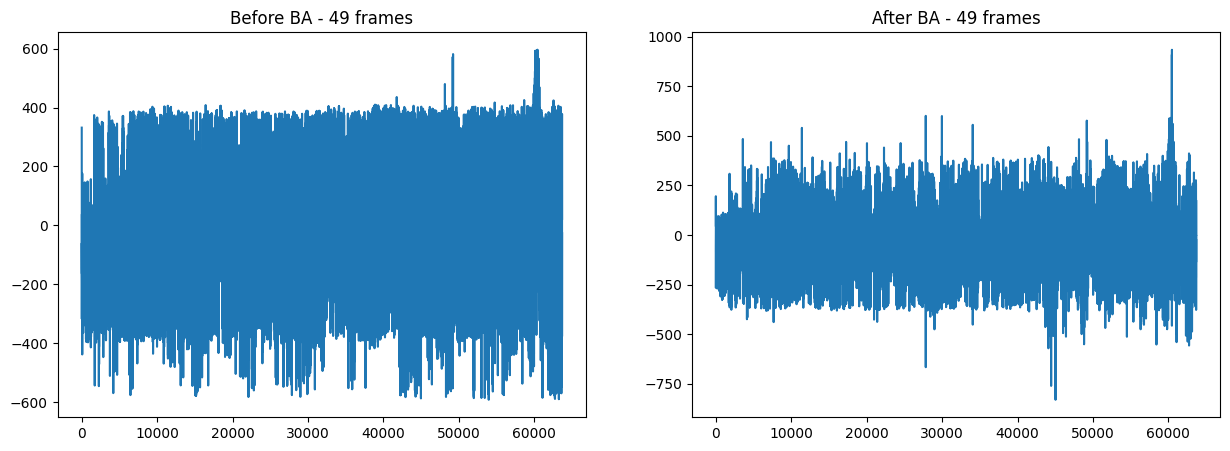

In [86]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

num_frames = len(temp_camera_params)
# num_frames = len(camera_params)

axs[0].plot(f0)
axs[0].set_title(f'Before BA - {num_frames} frames')

axs[1].plot(res.fun)
axs[1].set_title(f'After BA - {num_frames} frames')

plt.show()

In [87]:
optimized_params = res.x
final_cost = res.cost

# initial_cost = np.sum(func(x0, *args) ** 2)
initial_cost = np.sum(func(temp_x0, *args) ** 2)

cost_reduction = initial_cost - final_cost

num_iterations = res.nfev

print("Optimized Parameters (Shape):", optimized_params.shape)
print("Final Cost Value:", final_cost)
print("Cost Reduction:", cost_reduction)
print("Number of Iterations:", num_iterations)

Optimized Parameters (Shape): (23622,)
Final Cost Value: 336908372.2476251
Cost Reduction: 1922594902.696571
Number of Iterations: 250


### 3D-Points-Plot

In [88]:
# print(camera_params.shape, points_3d.shape, x0.shape)
# # x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
# opt_camera_params, opt_points_3d = optimized_params[:len(camera_params.ravel())].reshape(camera_params.shape), optimized_params[len(camera_params.ravel()):].reshape(points_3d.shape)
# print(opt_camera_params.shape, opt_points_3d.shape)

print(temp_camera_params.shape, temp_points_3d.shape, temp_x0.shape)
# x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
temp_opt_camera_params, temp_opt_points_3d = optimized_params[:len(temp_camera_params.ravel())].reshape(temp_camera_params.shape), optimized_params[len(temp_camera_params.ravel()):].reshape(temp_points_3d.shape)
print(temp_opt_camera_params.shape, temp_opt_points_3d.shape)

(49, 6) (7776, 3) (23622,)
(49, 6) (7776, 3)


BA-Cloud-View


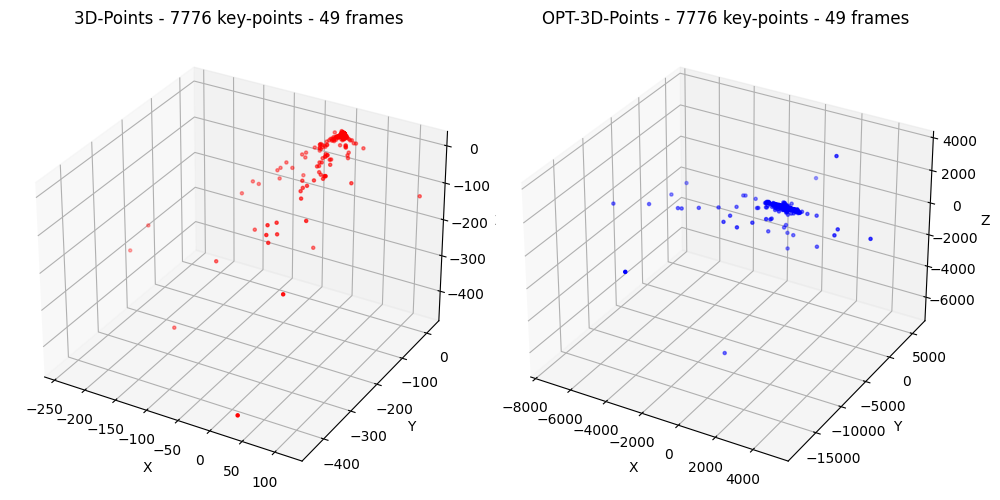

In [89]:
def point_3d_points(all_3d_points): ## During BA, how a 3D points in WCS changes + how camera pose for consecutive frames changes

    points_3d, opt_points_3d = all_3d_points
    print_num = len(points_3d)

    fig = plt.figure(figsize=(10, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the first 3D scatter plot
    ax1.scatter(points_3d[:print_num, 0], points_3d[:print_num, 1], points_3d[:print_num, 2], c='r', marker='.')
    ax1.set_title(f'3D-Points - {print_num} key-points - {num_frames} frames')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot the second 3D scatter plot
    ax2.scatter(opt_points_3d[:print_num, 0], opt_points_3d[:print_num, 1], opt_points_3d[:print_num, 2], c='b', marker='.')
    ax2.set_title(f'OPT-3D-Points - {print_num} key-points - {num_frames} frames')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

point_3d_points([temp_points_3d, temp_opt_points_3d])
# point_3d_points([points_3d, opt_points_3d])

print('BA-Cloud-View')

plt.tight_layout(pad = 2)
plt.show()

### Animate

BA-Cloud-View


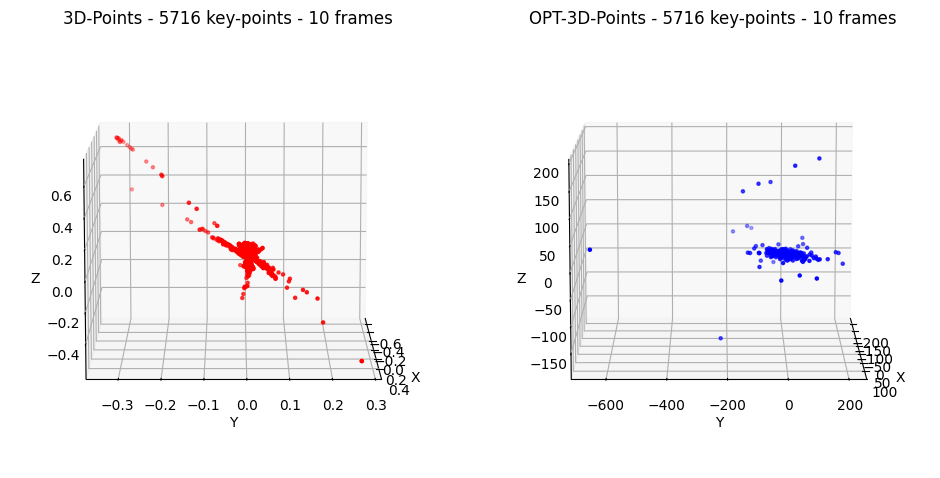

KeyboardInterrupt: 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import random
import string

def generate_random_string(length=8):
    
    characters = string.ascii_letters + string.digits
    
    random_string = ''.join(random.choice(characters) for _ in range(length))
    
    return random_string


def point_3d_points(all_3d_points):
    points_3d, opt_points_3d = all_3d_points

    print_num = len(points_3d)
    num_frames = len(camera_params)  # Assume a value for num_frames

    fig = plt.figure(figsize=(10, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Plot the first 3D scatter plot
    sc1 = ax1.scatter(points_3d[:print_num, 0], points_3d[:print_num, 1], points_3d[:print_num, 2], c='r', marker='.')
    ax1.set_title(f'3D-Points - {print_num} key-points - {num_frames} frames')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot the second 3D scatter plot
    sc2 = ax2.scatter(opt_points_3d[:print_num, 0], opt_points_3d[:print_num, 1], opt_points_3d[:print_num, 2], c='b', marker='.')
    ax2.set_title(f'OPT-3D-Points - {print_num} key-points - {num_frames} frames')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Create animation function
    def animate(i):
        ax1.view_init(elev=10, azim=i)
        ax2.view_init(elev=10, azim=i)
        return fig,

    # Create animation
    ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 360, 360), interval=50, blit=True)

    # Add toggle functionality
    toggle_animation = True

    def on_click(event):
        global toggle_animation
        if toggle_animation:
            ani.event_source.stop()
        else:
            ani.event_source.start()
        toggle_animation = not toggle_animation

    # Connect click event to the function
    fig.canvas.mpl_connect('button_press_event', on_click)

    print('BA-Cloud-View')
    plt.tight_layout(pad=2)
    plt.show()

    plt.close(fig)
    HTML(ani.to_html5_video())

    # Save the animation
    random_name = generate_random_string()
    ani.save(f'toggle_animation_{random_name}.mp4', writer='ffmpeg')
    
point_3d_points([points_3d, opt_points_3d])

### Optimized - Stitches

In [47]:
print(opt_camera_params.shape, opt_points_3d.shape)

(10, 6) (5716, 3)


Num-Frames:  10


Stitching frames: 100%|██████████| 10/10 [00:04<00:00,  2.23frame/s]


Execution-time (UNIX):  4.486092567443848


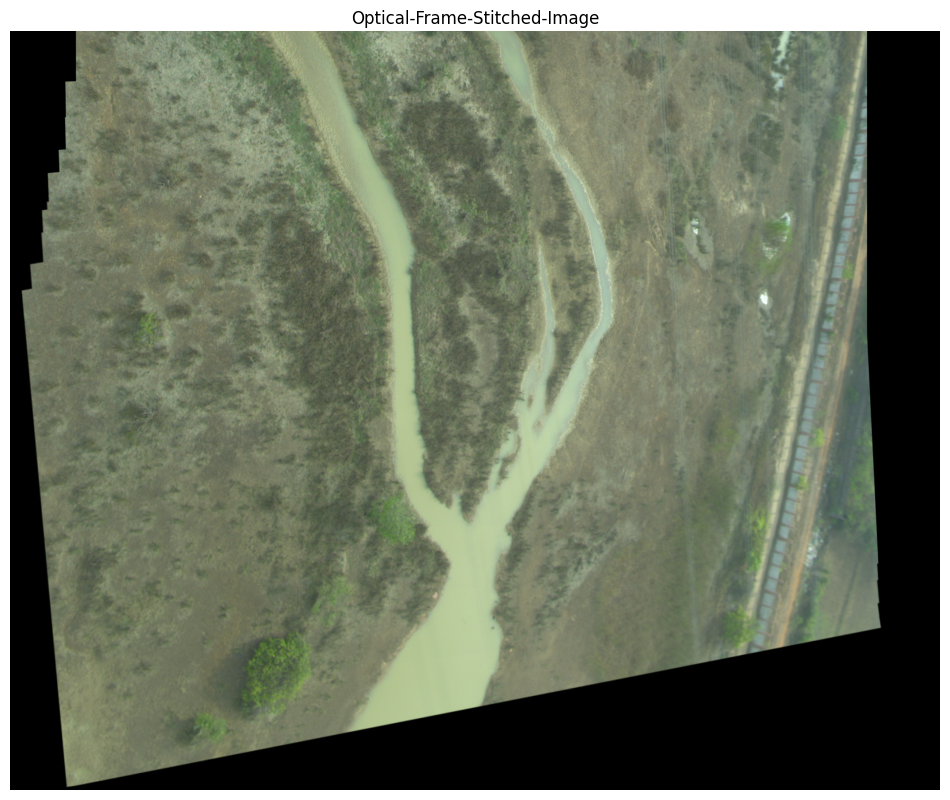

In [48]:
import time

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)

euler_angle_list = []
translation_list = []

t_corr = [False, t_err]

ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        opt_result_img = resized_frames[i]
        curr_R, _ = cv2.Rodrigues(opt_camera_params[0][:3])
        curr_t = opt_camera_params[0][3:].astype('float64')

    else:
        Image1 = opt_result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        ## BA Update
        t = opt_camera_params[i][3:]
        R, _ = cv2.Rodrigues(opt_camera_params[i][:3])

        # Calling function for stitching images.prev_t
        # eae = EAE(Image2, Image1)
        # _, t, euler_angle_rad, _ = eae.run(t_corr = t_corr, is_store = True)
        # euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        # R = euler_angles_to_rotation_matrix(euler_angle)
        # euler_angle_list.append(euler_angle)

        if i == 1:
          prev_R = curr_R
          prev_t = curr_t

          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        ''' There is a huge problem with implementation of manual_stitch_frames '''
        opt_result_img = manual_stitch_frames(Image2, Image1, prev_R, np.squeeze(prev_t), curr_R, np.squeeze(curr_t))

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

# opt_result_img = cv2.cvtColor(opt_result_img, cv2.COLOR_RGB2BGR)
# opt_result_img = cv2.resize(opt_result_img, image_size)

axs.imshow(opt_result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

### Differential

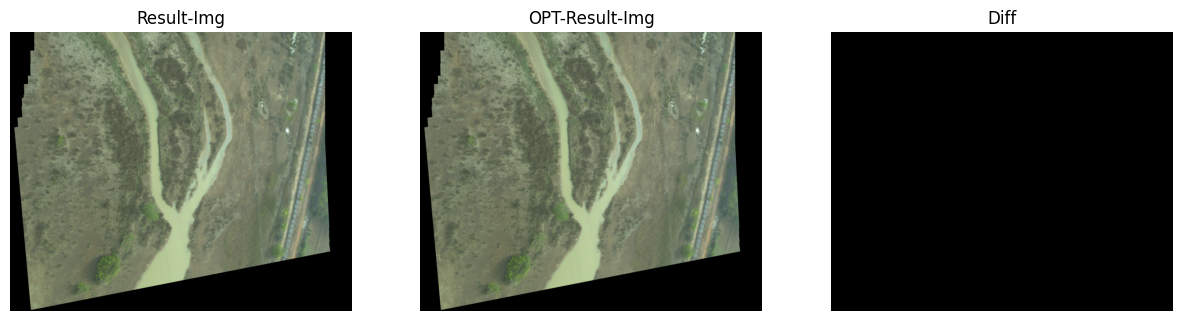

In [49]:
fig, axs = plt.subplots(1, 3, figsize = (15, 8))

axs[0].imshow(result_img)
axs[0].set_title('Result-Img')
axs[0].axis('off')

axs[1].imshow(opt_result_img)
axs[1].set_title('OPT-Result-Img')
axs[1].axis('off')

axs[2].imshow((result_img / 255).astype(np.float32) - (opt_result_img / 255).astype(np.float32))
axs[2].set_title('Diff')
axs[2].axis('off')

plt.show()

### Frame-Wise

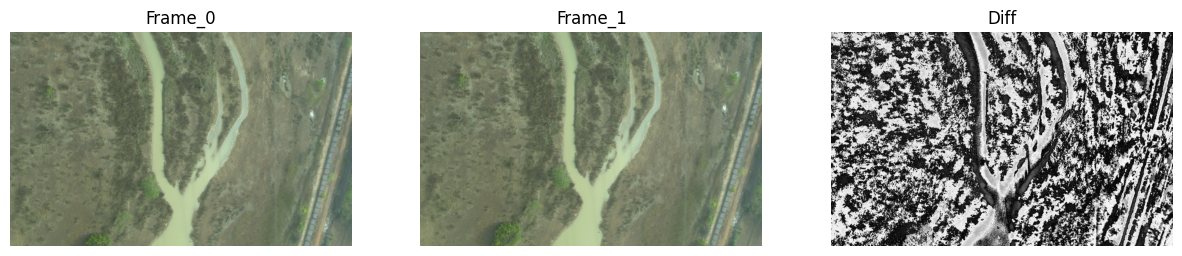

In [53]:
test_img_1, test_img_2 = cv2.imread(os.path.join(sample_dataset_path, sample_dir[0])), cv2.imread(os.path.join(sample_dataset_path, sample_dir[1]))
test_img_1, test_img_2 = cv2.cvtColor(test_img_1, cv2.COLOR_BGR2RGB), cv2.cvtColor(test_img_2, cv2.COLOR_BGR2RGB)


fig, axs = plt.subplots(1, 3, figsize = (15, 8))

axs[0].imshow(test_img_1)
axs[0].set_title('Frame_0')
axs[0].axis('off')

axs[1].imshow(test_img_2)
axs[1].set_title('Frame_1')
axs[1].axis('off')

diff_img = (test_img_1 / 255).astype(np.float32) - (test_img_2 / 255).astype(np.float32)
diff_img = (diff_img * 255).astype(np.uint8)

diff_img = cv2.cvtColor(diff_img, cv2.COLOR_BGR2GRAY)
axs[2].imshow(diff_img, cmap = 'gray')
axs[2].set_title('Diff')
axs[2].axis('off')

plt.show()

Using the optimized 3d_points + Camera extrinsics to improve stitching + ON Canvas creation + Alpha Blending

In [ ]:
def stitch_frames(images, optimized_points_3d, optimized_camera_params, intrinsic_matrix):
    """
    Stitches optical frames using the optimized 3D points and extrinsic parameters.

    """

In [ ]:
r = np.random.rand(3, 1)
print(r.shape)
temp = cv2.Rodrigues(r)
temp[0].shape

# camera_poses

(3, 1)


(3, 3)

In [ ]:
from PIL import Image

img = Image.open(r'/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6254.tif')

plt.imshow(img)
plt.show()

UnidentifiedImageError: cannot identify image file '/home/datademon/Desktop/Alik/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804114647_20190804114904_tile_6254.tif'